#Introduction

I will use the NLP and Multilabelbinarizer to predict genres in this project

Multilabelbinarizer allows you to encode multiple labels per instance. To translate the resulting array, you could build a DataFrame with this array and the encoded classes (through its "classes_" attribute).

#Data Set

We will use the  CMU Plot Summary Data set.

https://www.cs.cmu.edu/~ark/personas/data/

This dataset contains multiple files, but we’ll focus on only two of them for now:

movie.metadata.tsv: Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. The movie genre tags are available in this file.


plot_summaries.txt: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the plot summary.

#Import the required libraries

Notes: Some libraries I import here that we may not see I use that in the future but I did use that for some testings and I also will explain why I use those libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
import csv
import json
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity



import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Load Data

In [ ]:
#Open tsv data
file_path = "/content/movie.metadata.tsv"
data = pd.read_csv(file_path, sep = '\t', header = None)

In [ ]:
#Look at the data
data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
#Check the data shape, 81741 rows and 9 columns
data.shape

(81741, 9)

In [ ]:
#Adding Header
data.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [ ]:
#See data again after changing header name
data.head()

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
#Open the second data, read it line by line
file_path_2 = "/content/plot_summaries.txt"
plots = []

with open(file_path_2, 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:03, 12360.96it/s]


In [ ]:
#split the movie ids and the plots into two separate lists. We will use these lists to form a dataframe
movie_id = []
plot = []
#Extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|██████████| 42303/42303 [00:00<00:00, 427451.37it/s]


In [ ]:
#Create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [ ]:
#Look at the data
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


#Data Exploration and Pre-processing

In [ ]:
# change datatype of 'movie_id'
data['movie_id'] = data['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, data[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

In [ ]:
movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [ ]:
#An empty list
genres = []

#Extract genres
for i in movies['genre']:
  genres.append(list(json.loads(i).values()))
    
#Add the new column named genre_new to dataframe  
movies['genre_new'] = genres

In [ ]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [ ]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

We can see we have some rows have 0 genre 

In [ ]:
#Remove Nan value
movies_new.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


In [ ]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

We have 363 unique genre in this dataset. I want to do a lot of things with this data set but from this and the number of rows, we can see this is a big data set and when I try to do something(I will tell later) to perform a better explaination and result but my laptop crashed. I hope it does not affect the result of assessment, I will tell exactly what I will do if I have a strong machine.

Some next lines of codes I try to create the new data based on the genre and number of genres in each movies. For example, Movie A genre are Action and Drama so Action and Drama will have value 1 and other will have value 0

In [ ]:
values = []

for i in movies_new['genre_new']:
  values.append(i)


In [ ]:
df = pd.DataFrame(
    {'groups': values
    }, columns=['groups'])

s = df['groups']

mlb = MultiLabelBinarizer()

mydata = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
mydata


,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Right now, I create a new full data that is combined by the old data and the data I just created above for future using but I just can use in some cases, some cases not because as I said, my machine crash. I will tell you what I want to do later when we have that part.

In [ ]:
mydata_full = pd.concat([movies_new, mydata], axis=1, ignore_index=False)

In [ ]:
mydata_full.head(1)

,movie_id,plot,movie_name,genre,genre_new,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:

mydata_full_without_genre = mydata_full.drop(columns=['genre','genre_new'])
mydata_full_without_genre.head(1)


,movie_id,plot,movie_name,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#Drop some Nan values
mydata_full_without_genre.dropna(inplace=True)
mydata_full_without_genre.shape

(41385, 366)

In [ ]:
#Making sure the type of plot is string
mydata_full_without_genre['plot'] = mydata_full_without_genre['plot'].astype(str)

In [ ]:
category_columns= mydata.columns

#Number of Movies per genre

In [ ]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Number of Movies': list(all_genres.values())})

In [ ]:
all_genres_df['Percent'] = (all_genres_df['Number of Movies'] / all_genres_df['Number of Movies'].sum()) * 100
all_genres_df

,Genre,Number of Movies,Percent
0,Drama,19134,12.690433
1,World cinema,5153,3.417675
2,Action/Adventure,3553,2.356491
3,Science Fiction,2339,1.551318
4,Action,5868,3.891892
...,...,...,...
358,Statutory rape,1,0.000663
359,Silhouette animation,1,0.000663
360,Children's Issues,1,0.000663
361,Homoeroticism,1,0.000663


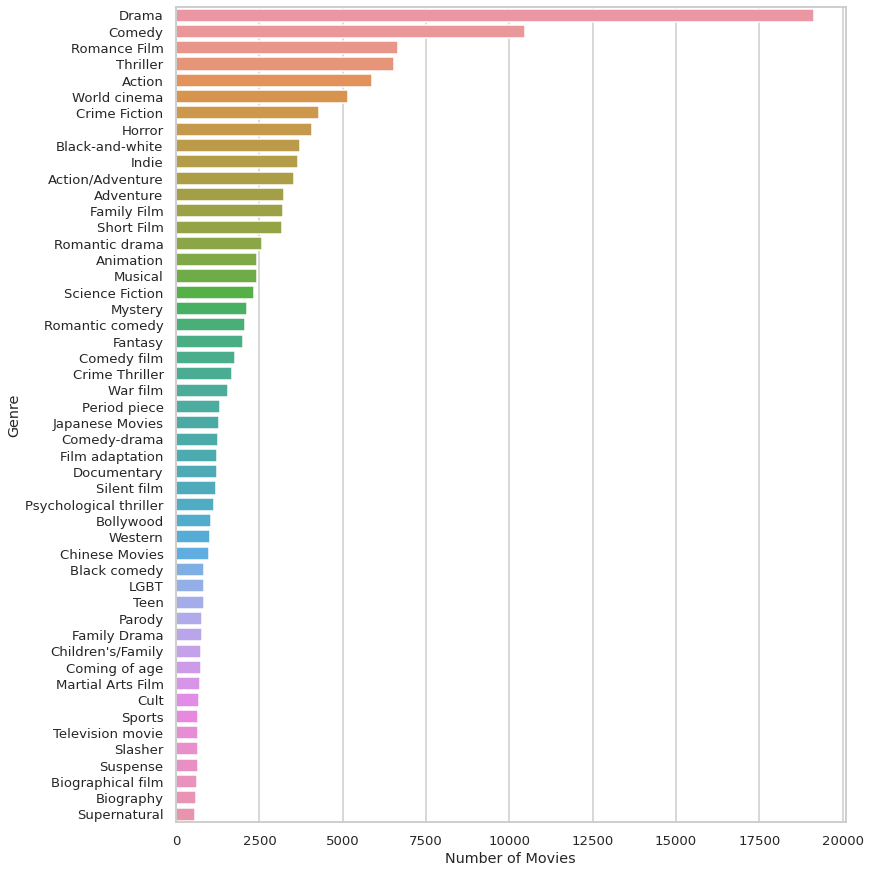

In [ ]:
g = all_genres_df.nlargest(columns="Number of Movies", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Number of Movies", y = "Genre")
ax.set(ylabel = 'Genre')
plt.show()

#Number of Genres per Movie

Here we can see because of creating the new data frame base on the genre so we can do the visualization below, we may not create the visualization below with the old dataset.

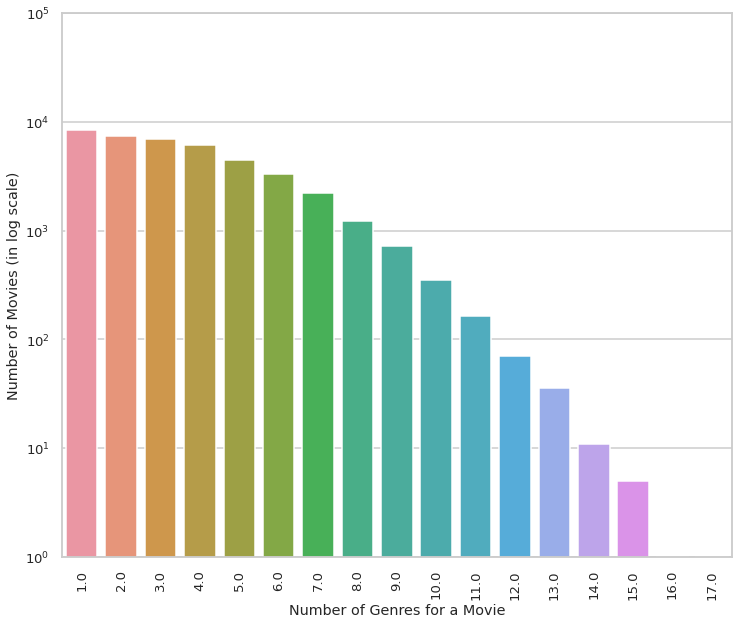

In [ ]:
sum_movie = mydata[category_columns].sum(axis=1)
df_genres_per_movie = pd.DataFrame({'title': movies_new.movie_name, 'num_genres':sum_movie}).groupby('num_genres').count()
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='title', axes=ax)
ax.set(yscale='log', ylim=(1, 1e5), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

#Data Preprocessing


We will apply some NLP technique to process the text in plot of this dataset.

In [ ]:
#Removing HTML tags
def remove_tags(sentence):
    html_tag = '<.*?>'
    cleaned_sentence = re.sub(html_tag, ' ',  str(sentence))
    return cleaned_sentence

In [ ]:
#Removing Accented Characters
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

In [ ]:
#Remove Punctuations
def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

In [ ]:
#Keeping only Alphabetic strings
def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', str(sentence))
    return alpha_sentence


In [ ]:
#Lower Case
def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

In [ ]:
#Stemming
def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

In [ ]:
#Lemmatize
def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

In [ ]:
#Stop Words
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

In [ ]:
#All text_prepocess in 1 function
def text_preprocess(sentence):
    pre_processed_sentence = remove_tags(sentence)
    pre_processed_sentence = remove_accents(pre_processed_sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

In [ ]:
movies_new['clean_plot'] = movies_new['plot'].apply(text_preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
movies_new[['plot', 'clean_plot']].sample(5)

,plot,clean_plot
1526,John suffered from epileptic seizures and an a...,john suffer epileptic seizures autism like dev...
38945,Sengathu Bhoomiyilae is the story of two close...,sengathu bhoomiyilae story closely relate fami...
14110,"In 1942, a small group of Allied soldiers and ...",small group ally soldier airmen station java b...
7263,"Pierre and Thérèse, two stuffy well-to-do volu...",pierre therese stuffy well volunteer telephone...
12648,17-year-old Tess Skinner is the daughter of a ...,year old tess skinner daughter squatter wealth...


Right here, I try to save the dataset that I already cleaned. I think it is a good habit and I also can use it in the future if I just lose the code I did. I also can start to do the next step without every thing above.

In [ ]:
movies_new.to_pickle('cleanned_data.pkl')

In [ ]:
#Here is the code I just apply for using the full data with each genre is each columns + the movies_new 
#mydata_full_without_genre['plot'] = mydata_full_without_genre['plot'].apply(text_preprocess)

In [ ]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

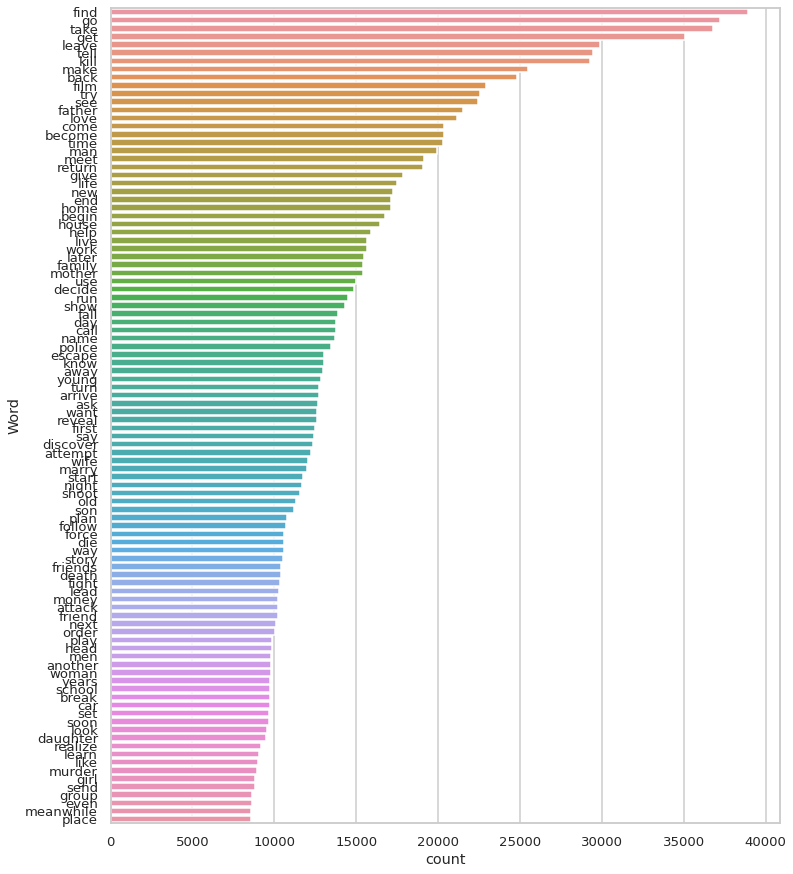

In [ ]:
# print 100 most frequent words
freq_words(movies_new['clean_plot'], 100)

We can do for each genre of the movies. But in this data set, we have 363 unique genre so my computer again can not do that I just tell it in here so if we have a project like this in the future and better machine than mine so we will have much more good visualization rather than just coding.

Link for example:

https://milady.cengage.com/wp-content/uploads/2018/11/word-cloud.jpg

In [ ]:
#Coding for world cloud
# def save_wordcloud_plots(mydata, labels):
#     for idx, col in enumerate(labels):
#         wordcloud = WordCloud(max_font_size=50).generate(' '.join(mydata[mydata[col]==1]['plot']))
#         ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
#         ax.imshow(wordcloud)
#         ax.axis("off")
#         ax.set(title='Movie Genre: {0}'.format(col))
#         plt.savefig('./../Images/results/wordcloud_{0}.png'.format(col), bbox_inches='tight')
#         plt.close()

# fig = plt.figure(figsize=(18, 70))
# num_cols = 2
# num_rows = math.ceil(len(category_columns)/num_cols)
# for idx, col in enumerate(category_columns):
#     wordcloud = WordCloud(max_font_size=50).generate(' '.join(mydata[mydata[col]==1]['plot']))
#     ax = fig.add_subplot(num_rows, num_cols, idx+1)
#     ax.imshow(wordcloud)
#     ax.axis("off")
#     ax.set(title='Movie Genre: {0}'.format(col))
# plt.show()

We also can do some heat map.

Link for example:

https://www.researchgate.net/profile/Rodolfo-Miranda-Pereira/publication/341816250/figure/fig1/AS:897818017419275@1591067904519/Labels-co-occurrence-matrix.ppm

In [ ]:
# Heatmap relative to all numeric columns
# corr_matrix = (mydata[category_columns].astype('int')).corr()
# mask = np.array(corr_matrix)
# mask[np.tril_indices_from(mask)] = False
# corr_matrix = (100*corr_matrix//1)/10

# fig = plt.figure(figsize=(20, 20))
# sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
# plt.show()

We also can do some Multi-Genre Distribution Plots

In [ ]:
# def save_genre_pdf_given_genre_plots(data, labels):
#     for idx, col in enumerate(labels):
#         df_sum_given_genre = pd.DataFrame({'Genre':labels, 'Total': data[data[col]==1][labels].sum()})
#         df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
#         df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
#         ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
#         sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
#         ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
#         plt.xticks(rotation=90)
#         plt.savefig('./../Images/results/genre_pdf_given_{0}.png'.format(col), bbox_inches='tight')
#         plt.close()

# fig = plt.figure(figsize=(18, 60))
# num_cols = 3
# num_rows = math.ceil(len(category_columns)/num_cols)
# for idx, col in enumerate(category_columns):
#     df_sum_given_genre = pd.DataFrame({'Genre':category_columns, 'Total': mydata[mydata[col]==1][category_columns].sum()})
#     df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
#     df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
#     ax = fig.add_subplot(num_rows, num_cols, idx+1)
#     sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
#     ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
#     plt.xticks(rotation=90)

# plt.tight_layout()
# plt.show()

Number of Genres given a Genre

In [ ]:
# def save_numGenre_pdf_given_genre_plots(data, labels):
#     for idx, col in enumerate(labels):
#         df_genres_per_movie = pd.DataFrame({'Total': data[data[col]==1][labels].sum(axis=1)})
#         df_numG_given_genre = pd.DataFrame(df_genres_per_movie['Total'].value_counts().sort_index().head(10))
#         df_numG_given_genre['Total'] = df_numG_given_genre['Total']/df_numG_given_genre['Total'].max()
#         ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
#         sns.barplot(data=df_numG_given_genre, x=df_numG_given_genre.index, y='Total', axes=ax)
#         ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
#         plt.savefig('./../Images/results/numGenre_pdf_given_{0}.png'.format(col), bbox_inches='tight')
#         plt.close()

# fig = plt.figure(figsize=(18, 50))
# num_cols = 3
# num_rows = math.ceil(len(category_columns)/num_cols)
# for idx, col in enumerate(category_columns):
#     df_genres_per_movie = pd.DataFrame({'Total': mydata[mydata[col]==1][category_columns].sum(axis=1)})
#     df_numG_given_genre = pd.DataFrame(df_genres_per_movie['Total'].value_counts().sort_index().head(10))
#     df_numG_given_genre['Total'] = df_numG_given_genre['Total']/df_numG_given_genre['Total'].max()
#     ax = fig.add_subplot(num_rows, num_cols, idx+1)
#     sns.barplot(data=df_numG_given_genre, x=df_numG_given_genre.index, y='Total', axes=ax)
#     ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')

# plt.tight_layout()
# plt.show()

#Finding the similarity of the movies

We can see the below of the code, I just go through 15000 movies because if I go more, my machine crashes. So I may not get a good result at the end. But I try to clarified why my result is not good and how to make it better.

This one is just my new approach so please bare with me, we will see the one given later

In [ ]:
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(movies_new['clean_plot'][0:15000]).toarray()
vector.shape

(15000, 5000)

In [ ]:
similarity = cosine_similarity(vector)

In [ ]:
similarity

array([[1.        , 0.0361761 , 0.01660452, ..., 0.01118384, 0.03962144,
        0.        ],
       [0.0361761 , 1.        , 0.12233984, ..., 0.07188172, 0.04347826,
        0.02992379],
       [0.01660452, 0.12233984, 1.        , ..., 0.07966623, 0.06842107,
        0.05493904],
       ...,
       [0.01118384, 0.07188172, 0.07966623, ..., 1.        , 0.04032389,
        0.00925094],
       [0.03962144, 0.04347826, 0.06842107, ..., 0.04032389, 1.        ,
        0.        ],
       [0.        , 0.02992379, 0.05493904, ..., 0.00925094, 0.        ,
        1.        ]])

In [ ]:
movies_new[movies_new['movie_name'] == 'Taxi Blues'].index[0]

0

In [ ]:
def recommend(movie):
    index = movies_new[movies_new['movie_name'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(movies_new.iloc[i[0]].movie_name)

In [ ]:
recommend('Taxi Blues')

Crazy Fruit
Hannah Takes the Stairs
Love in Space
Love and Other Disasters
Soundless Wind Chime


#Converting Text to Features

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [ ]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

#Build Movie Genre Prediction Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [ ]:
lr = LogisticRegression()

Right here, we can see I put only the Logistic Regression. We can try more model like RandomForestClassifer, LinearSVC,.... then print the score and take the best model. But I can not do that because if I fit more model and do that then my computer crashed. I did it and that's why we can see I did import some libraries at the top. 

In [ ]:
for classifer in [lr]:
  clf = OneVsRestClassifier(classifer)
  clf.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: La

In [ ]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [ ]:
jaccard = np.minimum(yval, y_pred).sum(axis=1)/np.maximum(yval, y_pred).sum(axis=1)
jaccard.mean()*100

23.415453760432403

In [ ]:
y_pred[15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
all_genres_df.head()

,Genre,Number of Movies,Percent
0,Drama,19134,12.690433
1,World cinema,5153,3.417675
2,Action/Adventure,3553,2.356491
3,Science Fiction,2339,1.551318
4,Action,5868,3.891892


In [ ]:
result= multilabel_binarizer.inverse_transform(y_pred)[15]
result


('Comedy', 'Drama', 'Romance Film')

In [ ]:
all_genres_df

,Genre,Number of Movies,Percent
0,Drama,19134,12.690433
1,World cinema,5153,3.417675
2,Action/Adventure,3553,2.356491
3,Science Fiction,2339,1.551318
4,Action,5868,3.891892
...,...,...,...
358,Statutory rape,1,0.000663
359,Silhouette animation,1,0.000663
360,Children's Issues,1,0.000663
361,Homoeroticism,1,0.000663


Multi-label classification problems must be assessed using different performance measures than single-label classification problems. Two of the most common performance metrics are hamming loss and Jaccard similarity. Hamming loss is the average fraction of incorrect labels. Note that hamming loss is a loss function and that the perfect score is 0. Jaccard similarity, or the Jaccard index, is the size of the intersection of the predicted labels and the true labels divided by the size of the union of the predicted and true labels. It ranges from 0 to 1, and 1 is the perfect score. 

In [ ]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.32136317395727365

In [ ]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)


In [ ]:
jaccard = np.minimum(yval, y_pred).sum(axis=1)/np.maximum(yval, y_pred).sum(axis=1)
jaccard.mean()*100

23.415453760432403

We try to put the threshold in there and we can see better performance

In [ ]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)


In [ ]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.440426048922728

In [ ]:
jaccard = np.minimum(yval, y_pred_new).sum(axis=1)/np.maximum(yval, y_pred_new).sum(axis=1)
jaccard.mean()*100

32.092811504769735

In [ ]:
multilabel_binarizer.inverse_transform(y_pred_new)[20]

('Crime Fiction',
 'Crime Thriller',
 'Drama',
 'Mystery',
 'Psychological thriller',
 'Thriller')

#Traditional vs Deep Learning Approaches

There is the huge difference in the performance of traditional machine learning approaches such as SVMs and Random Forests when compared to deep-learning like Sentence FCNNs, LSTM,... They are all use the same inputs which are the embeddings generated using the Doc2Vec Model. I think deep learning based approaches tend to generalize a lot better as compared to traditional methods and hence they also tried to see how these methods perform if the testing data is just a subset of training data. When the number of data points increases, deep learning based approaches show tremendous amounts of generalizability which allows them to attain much higher accuracies compared to traditional methods.

In this challenger, I don't use Deep-Learning for this because this is quite large data set and my machine can not run and crash if I try to do that. But I try tell to notice what we can do to improve our model and reach the highest result compare to others.

#Create Inference Function

We also have to take care of the new data or new movie plots that will come in the future, right? Our movie genre prediction system should be able to take a movie plot in raw form as input and generate its genre.

In here, I create one more solution. It is the first solution. But in here, I take random 5 movies names and their plot from the test dataset. Then I use it to predict the genres, scores and also the similar movies.

The solution the company want me to do below but I just want to create one more scenario. 

In [ ]:
def jac(yval,y_pred_new):
  jaccard = np.minimum(yval, y_pred_new).sum(axis=1)/np.maximum(yval, y_pred_new).sum(axis=1)
  return jaccard.mean()*100

In [ ]:
def final_score(genre):
  similar = []
  score = []
  for i in genre:
    similar.append(int(all_genres_df[all_genres_df['Genre']==i]['Number of Movies']))
  for i in similar:
    score.append(round(i/sum(similar)*100))
  return score



In [ ]:
def infer_tags(q):
    q = text_preprocess(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict_proba(q_vec)
    q_pred_new = (q_pred >= 0.3).astype(int)
    return multilabel_binarizer.inverse_transform(q_pred_new)

def pred(q):
    q = text_preprocess(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict_proba(q_vec)
    q_pred_new = (q_pred >= 0.3).astype(int)
    return q_pred_new


We can see I comment the print similar film

In [ ]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), 
    print("Actual genre: ",movies_new['genre_new'][k])
    print("Jaccard Score: ",jac(yval,pred(xval[k])), "\n")
    #print("Similar Film: ",recommend(movies_new['movie_name'][k]), "\n")

Movie:  The Stranger Beside Me 
Predicted genre:  [('Drama', 'Thriller')]
Actual genre:  ['Crime Fiction', 'Thriller', 'Television movie', 'Mystery', 'Drama', 'Suspense', 'Crime Thriller']
Jaccard Score:  14.710484280549654 

Movie:  Sakura Wars: The Movie 
Predicted genre:  [()]
Actual genre:  ['Science Fiction', 'Japanese Movies', 'Adventure', 'World cinema', 'Animation', 'Anime', 'Fantasy', 'Slice of life story', 'Action', 'Sci-Fi Adventure']
Jaccard Score:  0.0 

Movie:  Amandla! A Revolution in Four Part Harmony 
Predicted genre:  [('Documentary', 'Drama', 'Musical')]
Actual genre:  ['Music', 'Historical fiction', 'Documentary']
Jaccard Score:  10.62804006094955 

Movie:  Sylvia 
Predicted genre:  [('Drama', 'Period piece', 'Romance Film', 'Romantic drama')]
Actual genre:  ['Biography', 'Period piece', 'Drama', 'Romantic drama', 'Romance Film', 'Biographical film']
Jaccard Score:  11.635637592438016 

Movie:  Elegy 
Predicted genre:  [('Comedy', 'Drama', 'Indie', 'Romance Film')]


#Final Solution

Here is the final solution, we just given the plot in txt file and our job is predicting the movies genre of that plot, score and also giving the similar movies

In [ ]:
with open('movies_plot_summary.txt') as f:
    contents = f.read()
contents

'Chapter One – Down the Rabbit Hole: Alice, a seven-year-old girl, is feeling bored and tired while sitting on the riverbank with her elder sister. She notices a talking, clothed white rabbit with a pocket watch run past. She follows it down a rabbit hole where she suddenly falls a long way to a curious hall with many locked doors of all sizes. She finds a little key to a door too small for her to fit through, but through it, she sees an attractive garden. She then discovers a bottle on a table labelled "DRINK ME," the contents of which cause her to shrink too small to reach the key which she had left on the table. She subsequently eats a cake labelled "EAT ME" in currants as the chapter closes.\n\nChapter Two – The Pool of Tears: The chapter opens with Alice growing to such a tremendous size that her head hits the ceiling. Unhappy, Alice begins to cry and her tears literally flood the hallway. After she picks up a fan that causes her to shrink back down, Alice swims through her own te

In [ ]:
#We process the text and give genres back
def infer_tags(q):
    q = text_preprocess(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict_proba(q_vec)
    q_pred_new = (q_pred >= 0.3).astype(int)
    return multilabel_binarizer.inverse_transform(q_pred_new)


With the score, I am not sure what to do with that. I am using the Multilabel_binarizer, for example, the model predict it is that genre then it gives 1 and if it not it gonna give 0. The score of the above solution I can give because I have the y validation and y prediction then I have something to compare and give the score later. But in here I only have the y prediction of the plot we just given but if I compare it with just the y val I already have then I think it will give me the wrong result.

It is just what I think and I may made mistake with this one. I hope I can have some ideas about the new approach.

So I try to think another solution is just base on the population of the genre I have. For example, my data set is 30% movies about Drama and 10% is Action. Then when I have the genre are Action and Drama then I will favor the Drama is the main genre. I think it is not a good approach to do that, I hope I can have another approach.

One last things, I have one more approach. I can try to use the given plot to predict not only the genre, but also the name of the movies. And then based one the name of the movies, I can have the score later. It also good with the similar one but the way is expensive computation. Like even when we search in google some plot we remember in our head and try to find the movies we watched before but google even can not find it out. The reason is we have a lot a lot of movies name and just based on some words we may not find the right one. But I think we can do that if we have not too big dataset and also have a strong computer.

In [ ]:

def final_score(genre):
  similar = []
  score = []
  for i in genre:
    for j in i:
      similar.append(int(all_genres_df[all_genres_df['Genre']==j]['Number of Movies']))
  for i in similar:
    score.append(round(i/sum(similar)*100))
  return score


In here I try to remove the index of the dataframe. For example, we will see at the final result we have some thing like this:

511         A Smile as Big as the Moon

534                   Kadhayile Nayika

511 and 534 is the index of the dataframe and we don't need to show that in the result. But this dataset is kind of large and when I do that, my computer again crashed. I just put the solution here so we can do that with better computer than mine.

In [ ]:
#movies_new.to_string(index=False)


In [ ]:
def similar_movies(genre):
  similar =[]
  a=[]
  for i in infer_tags(contents):
    for j in i:
      a.append([j])

  similar.append(movies_new.loc[movies_new['genre_new'].isin(a)]['movie_name'])
  return similar


In [ ]:
def final_report(text):
  genre = "Genre:"
  score = "Score:"
  similar = "Similar Movies"
  infer_tags(text)
  final_score(infer_tags(text))
  similar_movies(infer_tags(text))
  return genre, infer_tags(text),score,  final_score(infer_tags(text)), similar, similar_movies(infer_tags(text))

In [ ]:
final_report(contents)

('Genre:',
 [('Animation', 'Family Film', 'Fantasy')],
 'Score:',
 [32, 42, 26],
 'Similar Movies',
 [511         A Smile as Big as the Moon
  534                   Kadhayile Nayika
  678              Chhota Bheem & Ganesh
  784      Max Steel: Endangered Species
  803                     Helter Shelter
                       ...              
  41649               Bhooter Bhabishyat
  41653                   Fairly OddBaby
  41848     Tenchi Muyo! Mihoshi Special
  41999        The Cat that Hated People
  42098          Arai Enn 305-il Kadavul
  Name: movie_name, Length: 248, dtype: object])